# Pokemon type classifier

This project takes a dataset with Pokémon sprites and trains a CNN to classify whether a Pokémon belongs to a certain type (e.g. water: true or false). It is meant as a demo to show how DVC can be used in deep learning scenarios.

## Imports and parameters

In [1]:
import math
import os
import re
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, log_loss)
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tqdm import tqdm

In [2]:
SEED: int = 42
POKEMON_TYPE_TRAIN: str = "Water"
    
SOURCE_DIRECTORY: str = "data/external"
DESTINATION_DIRECTORY: str = "data/processed"
TRAIN_DATA_IMAGES: str = "images-gen-1-8"
TRAIN_DATA_LABELS: str = "stats/pokemon-gen-1-8.csv"

MODEL_TEST_SIZE: float = 0.2
MODEL_LEARNING_RATE: float = 0.001
MODEL_EPOCHS: int = 10
MODEL_BATCH_SIZE: int = 120

In [3]:
# Parameters
SEED = 42
POKEMON_TYPE_TRAIN = "Water"
SOURCE_DIRECTORY = "data/external"
DESTINATION_DIRECTORY = "data/processed"
TRAIN_DATA_IMAGES = "images-gen-1-8"
TRAIN_DATA_LABELS = "stats/pokemon-gen-1-8.csv"
MODEL_TEST_SIZE = 0.2
MODEL_LEARNING_RATE = 0.001
MODEL_EPOCHS = 15
MODEL_BATCH_SIZE = 120


In [4]:
def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()

## Data preprocessing

In [5]:
# Process Pokémon and one-hot encode the types

def preprocess_training_labels(dataset) -> pd.DataFrame:
    pokemon = pd.read_csv(PROJECT_ROOT / SOURCE_DIRECTORY / dataset)
    pokemon = pokemon[["pokedex_number", "name", "type1", "type2"]]

    # Create one-hot columns for each type
    types = set(pokemon["type1"])
    for t in types:
        pokemon["is" + str(t).capitalize()] = 0

    # Iterate over Pokémon
    for i, p in pokemon.iterrows():

        #  Set one-hot columns to 1 for relevant types
        pokemon.loc[i, "is" + p["type1"].capitalize()] = 1

        if not pd.isna(p["type2"]):
            pokemon.loc[i, "is" + p["type2"].capitalize()] = 1
            
    # Save output
    pokemon.to_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon.csv', index=False)
            
    return(pokemon)

pokemon = preprocess_training_labels(TRAIN_DATA_LABELS)
pokemon.head()

,pokedex_number,name,type1,type2,isGhost,isGround,isDragon,isPoison,isIce,isGrass,...,isSteel,isElectric,isFlying,isFighting,isRock,isWater,isPsychic,isBug,isNormal,isFairy
0,1,Bulbasaur,grass,poison,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Ivysaur,grass,poison,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Venusaur,grass,poison,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Charmander,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Charmeleon,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Process image data

def preprocess_training_data(dataset) -> pd.DataFrame:

    data_directory_images = PROJECT_ROOT / SOURCE_DIRECTORY / dataset
    output_directory = PROJECT_ROOT / DESTINATION_DIRECTORY / "pokemon"

    pokemon = pd.read_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon.csv')
    pokemon["imagePath"] = np.nan

    # Remove processed folder and create empty new one
    try:
        shutil.rmtree(output_directory)
        os.mkdir(output_directory)
    except:
        os.mkdir(output_directory)

    # Copy images to processed folder
    for image in os.listdir(data_directory_images):
        pokemon_id = image.split('.')[0]

        # Add leading zeroes to ID
        while len(pokemon_id) < 3:
            pokemon_id = "0" + pokemon_id

        # Images with no variety (e.g. "211.png")
        if pokemon_id.isnumeric():

            # Copy to processed folder
            src = data_directory_images / image
            dst = os.path.join(output_directory, pokemon_id + ".png")
            shutil.copyfile(src, dst)

            # Set image path in data frame
            pokemon.loc[pokemon["pokedex_number"] == int(pokemon_id), 'imagePath'] = dst

    # Drop Pokemon without image path
    pokemon = pokemon.dropna(subset=["imagePath"])
    
    # Save pokemon.csv with image paths
    pokemon.to_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon-with-image-paths.csv', index=False)
    
    return(pokemon)

pokemon = preprocess_training_data(TRAIN_DATA_IMAGES)
pokemon.head()

,pokedex_number,name,type1,type2,isGhost,isGround,isDragon,isPoison,isIce,isGrass,...,isElectric,isFlying,isFighting,isRock,isWater,isPsychic,isBug,isNormal,isFairy,imagePath
0,1,Bulbasaur,grass,poison,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,/Users/robdewit/Documents/example-pokemon-clas...
1,2,Ivysaur,grass,poison,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,/Users/robdewit/Documents/example-pokemon-clas...
2,3,Venusaur,grass,poison,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,/Users/robdewit/Documents/example-pokemon-clas...
3,4,Charmander,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/Users/robdewit/Documents/example-pokemon-clas...
4,5,Charmeleon,fire,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/Users/robdewit/Documents/example-pokemon-clas...


## Load training data and create split

In [7]:
# Load images as training data

def load_training_data(labels) -> np.array:
    train_image = []

    for i in tqdm(range(labels.shape[0])):

        img = tf.keras.utils.load_img(labels.iloc[i]["imagePath"], color_mode='rgba')
        img = tf.keras.utils.img_to_array(img)
        img = img/255
        train_image.append(img)
    X = np.array(train_image)
    
    return(X)

X = load_training_data(pokemon)
X.shape
    
# Set dimensions for input sizes later on
model_image_size_x = len(X[1])
model_image_size_y = len(X[2])

  0%|                                                           | 0/801 [00:00<?, ?it/s]

  2%|▉                                                | 15/801 [00:00<00:05, 147.29it/s]

  4%|█▉                                               | 32/801 [00:00<00:04, 156.71it/s]

  6%|██▉                                              | 49/801 [00:00<00:04, 162.24it/s]

  8%|████                                             | 67/801 [00:00<00:04, 169.11it/s]

 11%|█████▎                                           | 86/801 [00:00<00:04, 175.79it/s]

 13%|██████▏                                         | 104/801 [00:00<00:03, 174.51it/s]

 15%|███████▎                                        | 122/801 [00:00<00:03, 174.68it/s]

 17%|████████▍                                       | 140/801 [00:00<00:03, 174.89it/s]

 20%|█████████▌                                      | 160/801 [00:00<00:03, 179.52it/s]

 22%|██████████▋                                     | 179/801 [00:01<00:03, 182.13it/s]

 25%|███████████▉                                    | 199/801 [00:01<00:03, 184.63it/s]

 27%|█████████████                                   | 218/801 [00:01<00:03, 183.11it/s]

 30%|██████████████▏                                 | 237/801 [00:01<00:03, 183.76it/s]

 32%|███████████████▎                                | 256/801 [00:01<00:02, 183.86it/s]

 34%|████████████████▍                               | 275/801 [00:01<00:02, 185.22it/s]

 37%|█████████████████▋                              | 295/801 [00:01<00:02, 189.14it/s]

 39%|██████████████████▊                             | 314/801 [00:01<00:02, 187.96it/s]

 42%|████████████████████                            | 334/801 [00:01<00:02, 189.52it/s]

 44%|█████████████████████▏                          | 353/801 [00:01<00:02, 188.32it/s]

 47%|██████████████████████▎                         | 373/801 [00:02<00:02, 189.67it/s]

 49%|███████████████████████▍                        | 392/801 [00:02<00:02, 188.15it/s]

 51%|████████████████████████▋                       | 411/801 [00:02<00:02, 187.04it/s]

 54%|█████████████████████████▊                      | 431/801 [00:02<00:01, 188.80it/s]

 56%|██████████████████████████▉                     | 450/801 [00:02<00:01, 188.13it/s]

 59%|████████████████████████████                    | 469/801 [00:02<00:01, 187.48it/s]

 61%|█████████████████████████████▏                  | 488/801 [00:02<00:01, 186.39it/s]

 63%|██████████████████████████████▍                 | 507/801 [00:02<00:01, 186.15it/s]

 66%|███████████████████████████████▌                | 526/801 [00:02<00:01, 183.51it/s]

 68%|████████████████████████████████▋               | 545/801 [00:02<00:01, 183.18it/s]

 70%|█████████████████████████████████▊              | 564/801 [00:03<00:01, 183.40it/s]

 73%|██████████████████████████████████▉             | 583/801 [00:03<00:01, 181.47it/s]

 75%|████████████████████████████████████            | 602/801 [00:03<00:01, 182.63it/s]

 78%|█████████████████████████████████████▏          | 621/801 [00:03<00:00, 183.61it/s]

 80%|██████████████████████████████████████▎         | 640/801 [00:03<00:00, 181.66it/s]

 82%|███████████████████████████████████████▍        | 659/801 [00:03<00:00, 182.13it/s]

 85%|████████████████████████████████████████▋       | 678/801 [00:03<00:00, 182.50it/s]

 87%|█████████████████████████████████████████▊      | 697/801 [00:03<00:00, 183.74it/s]

 89%|██████████████████████████████████████████▉     | 716/801 [00:03<00:00, 184.23it/s]

 92%|████████████████████████████████████████████    | 736/801 [00:04<00:00, 187.68it/s]

 94%|█████████████████████████████████████████████▎  | 756/801 [00:04<00:00, 190.05it/s]

 97%|██████████████████████████████████████████████▌ | 776/801 [00:04<00:00, 191.30it/s]

 99%|███████████████████████████████████████████████▋| 796/801 [00:04<00:00, 182.78it/s]

100%|████████████████████████████████████████████████| 801/801 [00:04<00:00, 182.97it/s]

In [8]:
# Create labels

def create_labels(labels):
    return(pokemon[["is" + POKEMON_TYPE_TRAIN]])

y = create_labels(pokemon)

In [9]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=MODEL_TEST_SIZE, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 475, 475, 4) (640, 1)
(161, 475, 475, 4) (161, 1)


## Define model and train

In [10]:
img_input = layers.Input(shape=(model_image_size_x, model_image_size_y, 4))

model = Sequential()

model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(model_image_size_x, model_image_size_y, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.2))

model.add(Dense(8, activation="relu"))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.Adam(learning_rate=MODEL_LEARNING_RATE) #Adam, RMSprop or SGD

model.compile(
    loss='binary_crossentropy'
    , optimizer=optimizer
    , metrics=[keras.metrics.AUC()]
#     , metrics=[keras.metrics.Recall()]
)

model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 471, 471, 4)       404       


 max_pooling2d (MaxPooling2D  (None, 235, 235, 4)      0         


 )                                                               


 dropout (Dropout)           (None, 235, 235, 4)       0         


 conv2d_1 (Conv2D)           (None, 231, 231, 4)       404       


 max_pooling2d_1 (MaxPooling  (None, 115, 115, 4)      0         


 2D)                                                             


 dense (Dense)               (None, 115, 115, 8)       40        


 dropout_1 (Dropout)         (None, 115, 115, 8)       0         


 flatten (Flatten)           (None, 105800)            0         


 dense_1 (Dense)             (None, 1)                 105801    


Total params: 106,649


Trainable params: 106,649


Non-trainable params: 0


_________________________________________________________________


2022-09-01 13:39:34.179990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-01 13:39:34.180121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# Now train the model

def calculate_class_weights(y_train):
    ratio_true = sum(y_train["isWater"] == 1) / len(y_train["isWater"])
    ratio_false = sum(y_train["isWater"] != 1) / len(y_train["isWater"])

    return {0: ratio_true, 1: ratio_false}


estimator = model.fit(X_train, y_train, 
                      validation_data=(X_test, y_test),
                      class_weight= calculate_class_weights(y_train),
                      epochs=MODEL_EPOCHS, 
                      batch_size=MODEL_BATCH_SIZE,
                      verbose=1)

Epoch 1/15


2022-09-01 13:39:35.973088: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2022-09-01 13:39:36.428568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/6 [====>.........................] - ETA: 12s - loss: 0.2767 - auc: 0.5556

2/6 [=========>....................] - ETA: 2s - loss: 0.2701 - auc: 0.4145 

3/6 [==============>...............] - ETA: 1s - loss: 0.2910 - auc: 0.4252

4/6 [===================>..........] - ETA: 1s - loss: 0.2916 - auc: 0.4480

5/6 [========================>.....] - ETA: 0s - loss: 0.2886 - auc: 0.4522

6/6 [==============================] - ETA: 0s - loss: 0.2873 - auc: 0.4535

2022-09-01 13:39:41.511209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 6s 695ms/step - loss: 0.2873 - auc: 0.4535 - val_loss: 0.8461 - val_auc: 0.5791


Epoch 2/15


1/6 [====>.........................] - ETA: 3s - loss: 0.2510 - auc: 0.7775

2/6 [=========>....................] - ETA: 1s - loss: 0.2607 - auc: 0.7682

3/6 [==============>...............] - ETA: 1s - loss: 0.2562 - auc: 0.7693

4/6 [===================>..........] - ETA: 0s - loss: 0.2533 - auc: 0.7842

5/6 [========================>.....] - ETA: 0s - loss: 0.2510 - auc: 0.7786

6/6 [==============================] - ETA: 0s - loss: 0.2526 - auc: 0.7708

6/6 [==============================] - 3s 540ms/step - loss: 0.2526 - auc: 0.7708 - val_loss: 0.7109 - val_auc: 0.5580


Epoch 3/15


1/6 [====>.........................] - ETA: 2s - loss: 0.2672 - auc: 0.8086

2/6 [=========>....................] - ETA: 1s - loss: 0.2461 - auc: 0.8354

3/6 [==============>...............] - ETA: 1s - loss: 0.2388 - auc: 0.8438

4/6 [===================>..........] - ETA: 0s - loss: 0.2443 - auc: 0.8513

5/6 [========================>.....] - ETA: 0s - loss: 0.2381 - auc: 0.8666

6/6 [==============================] - ETA: 0s - loss: 0.2368 - auc: 0.8707

6/6 [==============================] - 3s 484ms/step - loss: 0.2368 - auc: 0.8707 - val_loss: 0.6710 - val_auc: 0.5594


Epoch 4/15


1/6 [====>.........................] - ETA: 2s - loss: 0.2043 - auc: 0.8781

2/6 [=========>....................] - ETA: 1s - loss: 0.2153 - auc: 0.9067

3/6 [==============>...............] - ETA: 1s - loss: 0.2117 - auc: 0.9070

4/6 [===================>..........] - ETA: 0s - loss: 0.2105 - auc: 0.9016

5/6 [========================>.....] - ETA: 0s - loss: 0.2157 - auc: 0.8966

6/6 [==============================] - ETA: 0s - loss: 0.2160 - auc: 0.8945

6/6 [==============================] - 3s 481ms/step - loss: 0.2160 - auc: 0.8945 - val_loss: 0.6658 - val_auc: 0.5972


Epoch 5/15


1/6 [====>.........................] - ETA: 2s - loss: 0.1943 - auc: 0.9449

2/6 [=========>....................] - ETA: 1s - loss: 0.1887 - auc: 0.9300

3/6 [==============>...............] - ETA: 1s - loss: 0.1927 - auc: 0.9137

4/6 [===================>..........] - ETA: 0s - loss: 0.1908 - auc: 0.9173

5/6 [========================>.....] - ETA: 0s - loss: 0.1887 - auc: 0.9234

6/6 [==============================] - ETA: 0s - loss: 0.1885 - auc: 0.9229

6/6 [==============================] - 3s 479ms/step - loss: 0.1885 - auc: 0.9229 - val_loss: 0.5468 - val_auc: 0.6345


Epoch 6/15


1/6 [====>.........................] - ETA: 2s - loss: 0.1592 - auc: 0.9725

2/6 [=========>....................] - ETA: 2s - loss: 0.1645 - auc: 0.9615

3/6 [==============>...............] - ETA: 1s - loss: 0.1708 - auc: 0.9409

4/6 [===================>..........] - ETA: 1s - loss: 0.1709 - auc: 0.9297

5/6 [========================>.....] - ETA: 0s - loss: 0.1669 - auc: 0.9335

6/6 [==============================] - ETA: 0s - loss: 0.1669 - auc: 0.9322

6/6 [==============================] - 3s 520ms/step - loss: 0.1669 - auc: 0.9322 - val_loss: 0.5116 - val_auc: 0.6063


Epoch 7/15


1/6 [====>.........................] - ETA: 2s - loss: 0.1890 - auc: 0.9709

2/6 [=========>....................] - ETA: 1s - loss: 0.1628 - auc: 0.9515

3/6 [==============>...............] - ETA: 1s - loss: 0.1543 - auc: 0.9449

4/6 [===================>..........] - ETA: 0s - loss: 0.1518 - auc: 0.9480

5/6 [========================>.....] - ETA: 0s - loss: 0.1501 - auc: 0.9567

6/6 [==============================] - ETA: 0s - loss: 0.1502 - auc: 0.9568

6/6 [==============================] - 3s 489ms/step - loss: 0.1502 - auc: 0.9568 - val_loss: 0.5520 - val_auc: 0.5779


Epoch 8/15


1/6 [====>.........................] - ETA: 2s - loss: 0.1183 - auc: 0.9917

2/6 [=========>....................] - ETA: 1s - loss: 0.1227 - auc: 0.9944

3/6 [==============>...............] - ETA: 1s - loss: 0.1244 - auc: 0.9909

4/6 [===================>..........] - ETA: 0s - loss: 0.1241 - auc: 0.9919

5/6 [========================>.....] - ETA: 0s - loss: 0.1226 - auc: 0.9894

6/6 [==============================] - ETA: 0s - loss: 0.1211 - auc: 0.9897

6/6 [==============================] - 3s 464ms/step - loss: 0.1211 - auc: 0.9897 - val_loss: 0.5300 - val_auc: 0.6177


Epoch 9/15


1/6 [====>.........................] - ETA: 2s - loss: 0.0977 - auc: 1.0000

2/6 [=========>....................] - ETA: 1s - loss: 0.1114 - auc: 0.9942

3/6 [==============>...............] - ETA: 1s - loss: 0.1153 - auc: 0.9929

4/6 [===================>..........] - ETA: 0s - loss: 0.1124 - auc: 0.9903

5/6 [========================>.....] - ETA: 0s - loss: 0.1134 - auc: 0.9872

6/6 [==============================] - ETA: 0s - loss: 0.1129 - auc: 0.9871

6/6 [==============================] - 3s 478ms/step - loss: 0.1129 - auc: 0.9871 - val_loss: 0.5356 - val_auc: 0.6309


Epoch 10/15


1/6 [====>.........................] - ETA: 2s - loss: 0.0911 - auc: 1.0000

2/6 [=========>....................] - ETA: 2s - loss: 0.0964 - auc: 0.9994

3/6 [==============>...............] - ETA: 1s - loss: 0.1049 - auc: 0.9983

4/6 [===================>..........] - ETA: 0s - loss: 0.1005 - auc: 0.9970

5/6 [========================>.....] - ETA: 0s - loss: 0.0975 - auc: 0.9974

6/6 [==============================] - ETA: 0s - loss: 0.0973 - auc: 0.9970

6/6 [==============================] - 3s 491ms/step - loss: 0.0973 - auc: 0.9970 - val_loss: 0.5597 - val_auc: 0.6302


Epoch 11/15


1/6 [====>.........................] - ETA: 2s - loss: 0.0906 - auc: 1.0000

2/6 [=========>....................] - ETA: 1s - loss: 0.0869 - auc: 0.9993

3/6 [==============>...............] - ETA: 1s - loss: 0.0840 - auc: 0.9997

4/6 [===================>..........] - ETA: 0s - loss: 0.0829 - auc: 0.9995

5/6 [========================>.....] - ETA: 0s - loss: 0.0838 - auc: 0.9993

6/6 [==============================] - ETA: 0s - loss: 0.0842 - auc: 0.9993

6/6 [==============================] - 3s 467ms/step - loss: 0.0842 - auc: 0.9993 - val_loss: 0.5835 - val_auc: 0.6178


Epoch 12/15


1/6 [====>.........................] - ETA: 2s - loss: 0.0773 - auc: 1.0000

2/6 [=========>....................] - ETA: 1s - loss: 0.0768 - auc: 1.0000

3/6 [==============>...............] - ETA: 1s - loss: 0.0767 - auc: 0.9985

4/6 [===================>..........] - ETA: 0s - loss: 0.0770 - auc: 0.9990

5/6 [========================>.....] - ETA: 0s - loss: 0.0771 - auc: 0.9992

6/6 [==============================] - ETA: 0s - loss: 0.0769 - auc: 0.9992

6/6 [==============================] - 3s 458ms/step - loss: 0.0769 - auc: 0.9992 - val_loss: 0.6627 - val_auc: 0.6202


Epoch 13/15


1/6 [====>.........................] - ETA: 2s - loss: 0.0733 - auc: 1.0000

2/6 [=========>....................] - ETA: 1s - loss: 0.0751 - auc: 1.0000

3/6 [==============>...............] - ETA: 1s - loss: 0.0749 - auc: 0.9995

4/6 [===================>..........] - ETA: 0s - loss: 0.0725 - auc: 0.9997

5/6 [========================>.....] - ETA: 0s - loss: 0.0713 - auc: 0.9997

6/6 [==============================] - ETA: 0s - loss: 0.0712 - auc: 0.9997

6/6 [==============================] - 3s 475ms/step - loss: 0.0712 - auc: 0.9997 - val_loss: 0.6078 - val_auc: 0.6170


Epoch 14/15


1/6 [====>.........................] - ETA: 2s - loss: 0.0649 - auc: 1.0000

2/6 [=========>....................] - ETA: 1s - loss: 0.0668 - auc: 1.0000

3/6 [==============>...............] - ETA: 1s - loss: 0.0665 - auc: 1.0000

4/6 [===================>..........] - ETA: 0s - loss: 0.0651 - auc: 1.0000

5/6 [========================>.....] - ETA: 0s - loss: 0.0654 - auc: 1.0000

6/6 [==============================] - ETA: 0s - loss: 0.0660 - auc: 1.0000

6/6 [==============================] - 3s 418ms/step - loss: 0.0660 - auc: 1.0000 - val_loss: 0.7056 - val_auc: 0.5890


Epoch 15/15


1/6 [====>.........................] - ETA: 2s - loss: 0.0601 - auc: 1.0000

2/6 [=========>....................] - ETA: 1s - loss: 0.0611 - auc: 1.0000

3/6 [==============>...............] - ETA: 1s - loss: 0.0615 - auc: 1.0000

4/6 [===================>..........] - ETA: 0s - loss: 0.0605 - auc: 1.0000

5/6 [========================>.....] - ETA: 0s - loss: 0.0606 - auc: 1.0000

6/6 [==============================] - ETA: 0s - loss: 0.0609 - auc: 1.0000

6/6 [==============================] - 2s 387ms/step - loss: 0.0609 - auc: 1.0000 - val_loss: 0.7120 - val_auc: 0.5929


## Plot training history and save model

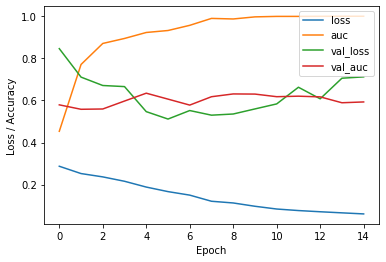

INFO:tensorflow:Assets written to: ram://2ab9b6e7-c394-401a-a7a6-46410d36204a/assets


INFO:tensorflow:Assets written to: ram://2ab9b6e7-c394-401a-a7a6-46410d36204a/assets


In [12]:
# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')

for k in estimator.history.keys():
    plt.plot(estimator.history[k], label = k) 
plt.legend(loc='best')

plt.savefig(PROJECT_ROOT / "outputs" / "train_history.png", dpi=150, bbox_inches='tight', pad_inches=0)
plt.show()

# Save model itself
pickle.dump(estimator, open(PROJECT_ROOT / "outputs" / "model.pckl", "wb"))

## Validation

0.98946035


2022-09-01 13:40:23.187378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


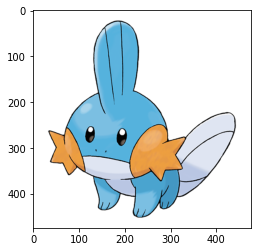

In [13]:
def predict_pokemon(id: str, verbose=0):
    
    while len(id) < 3:
        id = "0" + id
    
    img = tf.keras.utils.load_img(f'{PROJECT_ROOT}/{DESTINATION_DIRECTORY}/pokemon/{id}.png', color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255


    classes = y
    proba = model.predict(img.reshape(1,475,475,4), verbose=verbose)
    
    plt.clf()
    plt.imshow(img)
    
    return proba[0][0]

print(predict_pokemon("258"))

 1/26 [>.............................] - ETA: 7s

 3/26 [==>...........................] - ETA: 0s

 5/26 [====>.........................] - ETA: 0s

 7/26 [=======>......................] - ETA: 0s

 9/26 [=========>....................] - ETA: 0s

11/26 [===========>..................] - ETA: 0s

13/26 [==============>...............] - ETA: 0s

15/26 [================>.............] - ETA: 0s

17/26 [==================>...........] - ETA: 0s

19/26 [====================>.........] - ETA: 0s

21/26 [=======================>......] - ETA: 0s

23/26 [=========================>....] - ETA: 0s

25/26 [===========================>..] - ETA: 0s

26/26 [==============================] - 1s 30ms/step


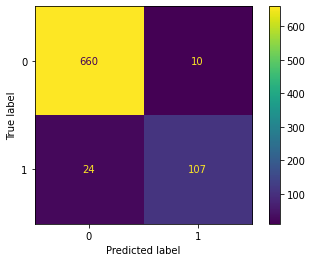

In [14]:
predictions = model.predict(X) > 0.5
cm = confusion_matrix(y, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.savefig(PROJECT_ROOT / "outputs" / "confusion_matrix.png", dpi=150, bbox_inches='tight', pad_inches=0)
plt.show()

*Attribution*:

- https://github.com/benckx/dnn-movie-posters
- https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080
- https://www.kaggle.com/datasets/rounakbanik/pokemon